In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Epoch [1/20], Loss: 0.0108
Epoch [2/20], Loss: 0.0055
Epoch [3/20], Loss: 0.0084
Epoch [4/20], Loss: 0.0072
Epoch [5/20], Loss: 0.0039
Epoch [6/20], Loss: 0.0042
Epoch [7/20], Loss: 0.0060
Epoch [8/20], Loss: 0.0053
Epoch [9/20], Loss: 0.0059
Epoch [10/20], Loss: 0.0040
Epoch [11/20], Loss: 0.0083
Epoch [12/20], Loss: 0.0084
Epoch [13/20], Loss: 0.0073
Epoch [14/20], Loss: 0.0084
Epoch [15/20], Loss: 0.0058
Epoch [16/20], Loss: 0.0061
Epoch [17/20], Loss: 0.0111
Epoch [18/20], Loss: 0.0095
Epoch [19/20], Loss: 0.0090
Epoch [20/20], Loss: 0.0064
Second Model Epoch [1/40], Loss: 0.0959
Second Model Epoch [2/40], Loss: 0.0485
Second Model Epoch [3/40], Loss: 0.0638
Second Model Epoch [4/40], Loss: 0.0579
Second Model Epoch [5/40], Loss: 0.0388
Second Model Epoch [6/40], Loss: 0.0473
Second Model Epoch [7/40], Loss: 0.0582
Second Model Epoch [8/40], Loss: 0.1026
Second Model Epoch [9/40], Loss: 0.0596
Second Model Epoch [10/40], Loss: 0.0394
Second Model Epoch [11/40], Loss: 0.0616
Second 

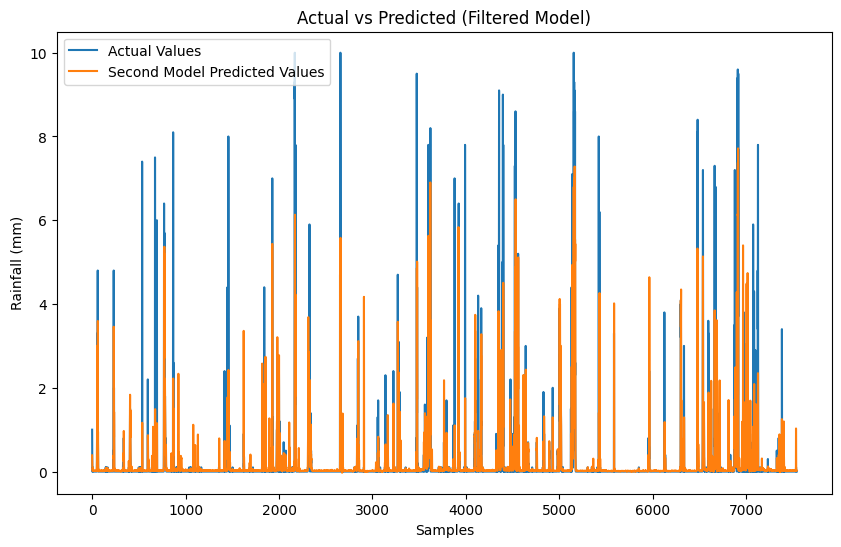

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/강수/final24.csv', encoding = 'cp949')

data = df

data = data[data['서울_강수량(mm)_1시간후'] <= 10]

# 로그 변환할 변수들 리스트
log_transform_columns = [
    '서울_강수량(mm)', '수원_강수량(mm)', '서산_강수량(mm)', '인천_강수량(mm)',
    '서울_강수량(mm)_1시간전', '서울_강수량(mm)_2시간전', '서울_강수량(mm)_3시간전',
    '수원_강수량(mm)_1시간전', '수원_강수량(mm)_2시간전', '수원_강수량(mm)_3시간전',
    '서산_강수량(mm)_1시간전', '서산_강수량(mm)_2시간전', '서산_강수량(mm)_3시간전',
    '인천_강수량(mm)_1시간전', '인천_강수량(mm)_2시간전', '인천_강수량(mm)_3시간전',
    '서울_강수량(mm)_1시간후', '서울_강수량(mm)_2시간후', '서울_강수량(mm)_3시간후'
]

# 로그 변환 적용
for column in log_transform_columns:
    if column in data.columns:
        data[column] = np.log1p(data[column])

# 데이터 준비 (가정: 이미 'data'라는 DataFrame이 존재)
columns = ['일시', '서울_강수량(mm)_1시간후', '서울_강수량(mm)_2시간후', '서울_강수량(mm)_3시간후']

# X, y 분리
X = data.drop(columns=columns)
y = data['서울_강수량(mm)_1시간후']

# 데이터 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 두 개의 범위 설정
range1 = np.arange(0, 61561)
range2 = np.arange(67420, 70365)

range3 = np.arange(61562, 67419)
range4 = np.arange(70366, len(y_scaled))

# 두 범위를 결합
combined_range_train = np.concatenate([range1, range2])
combined_range_test = np.concatenate([range3, range4])

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test = X_scaled[combined_range_train], X_scaled[combined_range_test]
y_train, y_test = y_scaled[combined_range_train], y_scaled[combined_range_test]

# PyTorch Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, X_train.shape[1])
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, X_test.shape[1])
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=744, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=744, shuffle=False)
'''
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out
'''
class LSTMDNNParallel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.5):
        super(LSTMDNNParallel, self).__init__()

        # LSTM 레이어
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)

        # DNN 레이어
        self.dnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # 10은 타임스텝의 크기
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size)
        )

        # 결합 후의 선형 레이어
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM 통과
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 타임스텝의 출력을 사용

        # DNN 통과 (DNN의 입력을 위해 배치 차원을 제외하고 나머지 차원 펼침)
        dnn_out = x.view(x.size(0), -1)  # 배치 크기 유지, 나머지 펼침
        dnn_out = self.dnn(dnn_out)

        # LSTM과 DNN 출력을 결합
        out = torch.cat((lstm_out, dnn_out), dim=1)

        # 결합된 출력을 선형 레이어에 전달하여 최종 출력
        out = self.fc1(out)
        out = self.fc2(out)

        return out

class WeightedMSELoss(nn.Module):
    def forward(self, input, target):
        loss = (input - target) ** 2
        loss = torch.where((target >= 0.008) & (target < 0.0115), loss * 3, loss)
        loss = torch.where((target >= 0.0115), loss * 10, loss)
        return loss.mean()

# 첫 번째 모델 초기화
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 4
model1 = LSTMDNNParallel(input_size, hidden_size, num_layers)
num_epochs1 = 20
criterion1 = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

# 두 번째 모델 초기화
model2 = LSTMDNNParallel(input_size, hidden_size, num_layers)
num_epochs2 = 40
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
criterion2 = WeightedMSELoss()

# 모델 학습
model1.train()
for epoch in range(num_epochs1):
    for X_batch, y_batch in train_loader:
        optimizer1.zero_grad()
        outputs = model1(X_batch)
        loss = criterion1(outputs, y_batch)
        loss.backward()
        optimizer1.step()
    print(f'Epoch [{epoch+1}/{num_epochs1}], Loss: {loss.item():.4f}')

# 첫 번째 모델 평가 및 0.002 이상인 데이터 필터링
model1.eval()
with torch.no_grad():
    y_pred_scaled = model1(X_test_tensor).numpy()
    y_train_pred_scaled = model1(X_train_tensor).numpy()

# 필터링된 데이터
filter_mask = y_train_pred_scaled >= 0.002
X_train_filtered = X_train[filter_mask.flatten()]
y_train_filtered = y_train[filter_mask.flatten()]

# 두 번째 모델 학습용 데이터 준비
X_train_filtered_tensor = torch.tensor(X_train_filtered, dtype=torch.float32).reshape(-1, 1, X_train_filtered.shape[1])
y_train_filtered_tensor = torch.tensor(y_train_filtered, dtype=torch.float32)

filtered_train_dataset = TensorDataset(X_train_filtered_tensor, y_train_filtered_tensor)
filtered_train_loader = DataLoader(filtered_train_dataset, batch_size=744, shuffle=True)

# 두 번째 모델 학습
model2.train()
for epoch in range(num_epochs2):
    for X_batch, y_batch in filtered_train_loader:
        optimizer2.zero_grad()
        outputs = model2(X_batch)
        loss = criterion2(outputs, y_batch)
        loss.backward()
        optimizer2.step()
    print(f'Second Model Epoch [{epoch+1}/{num_epochs2}], Loss: {loss.item():.4f}')

# 두 번째 모델 평가
model2.eval()
with torch.no_grad():
    y_pred_filtered_scaled = model2(X_test_tensor).numpy()

y_pred = np.where(y_pred_scaled < 0.05, y_pred_scaled, y_pred_filtered_scaled * 1.1)

# 예측값과 실제값을 역변환
y_pred_filtered_inverse = scaler_y.inverse_transform(y_pred)
y_test_inverse = scaler_y.inverse_transform(y_test_tensor.numpy())

# 로그 변환을 원래 값으로 되돌림
y_pred_filtered_original = np.expm1(y_pred_filtered_inverse)
y_pred_filtered_original = np.where(y_pred_filtered_original < 0.1, 0, y_pred_filtered_original)
y_test_original = np.expm1(y_test_inverse)

# R^2 평가
r2_filtered = r2_score(y_test_original, y_pred_filtered_original)
print(f"Second Model R^2 Score: {r2_filtered}")

# 예측 vs 실제값 그래프
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Values')
plt.plot(y_pred_filtered_original, label='Second Model Predicted Values')
plt.title('Actual vs Predicted (Filtered Model)')
plt.xlabel('Samples')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()


Epoch [1/20], Loss: 0.0118
Epoch [2/20], Loss: 0.0070
Epoch [3/20], Loss: 0.0052
Epoch [4/20], Loss: 0.0028
Epoch [5/20], Loss: 0.0083
Epoch [6/20], Loss: 0.0056
Epoch [7/20], Loss: 0.0067
Epoch [8/20], Loss: 0.0055
Epoch [9/20], Loss: 0.0083
Epoch [10/20], Loss: 0.0061
Epoch [11/20], Loss: 0.0092
Epoch [12/20], Loss: 0.0053
Epoch [13/20], Loss: 0.0068
Epoch [14/20], Loss: 0.0077
Epoch [15/20], Loss: 0.0077
Epoch [16/20], Loss: 0.0057
Epoch [17/20], Loss: 0.0079
Epoch [18/20], Loss: 0.0058
Epoch [19/20], Loss: 0.0063
Epoch [20/20], Loss: 0.0071
Second Model Epoch [1/40], Loss: 0.1310
Second Model Epoch [2/40], Loss: 0.1153
Second Model Epoch [3/40], Loss: 0.1041
Second Model Epoch [4/40], Loss: 0.1065
Second Model Epoch [5/40], Loss: 0.0691
Second Model Epoch [6/40], Loss: 0.1126
Second Model Epoch [7/40], Loss: 0.1179
Second Model Epoch [8/40], Loss: 0.1311
Second Model Epoch [9/40], Loss: 0.1064
Second Model Epoch [10/40], Loss: 0.1332
Second Model Epoch [11/40], Loss: 0.1335
Second 

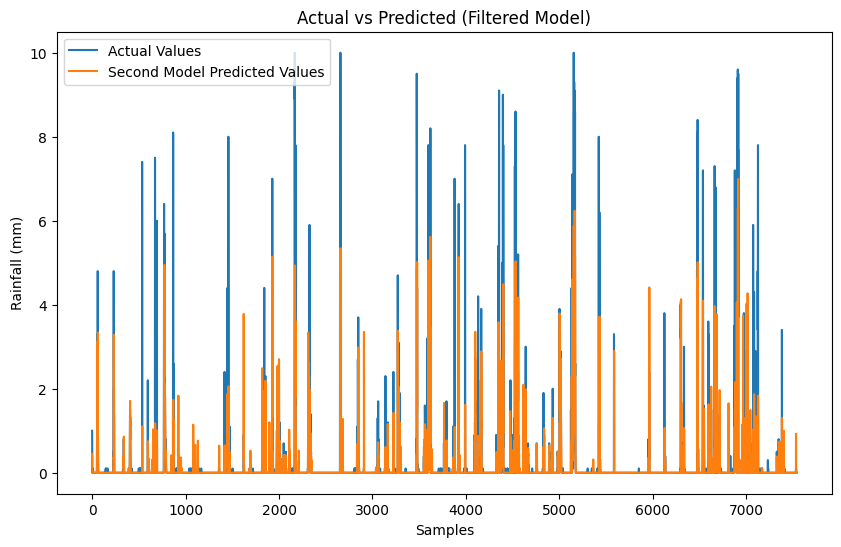

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/강수/final24.csv', encoding = 'cp949')

data = df

data = data[data['서울_강수량(mm)_1시간후'] <= 10]

# 로그 변환할 변수들 리스트
log_transform_columns = [
    '서울_강수량(mm)', '수원_강수량(mm)', '서산_강수량(mm)', '인천_강수량(mm)',
    '서울_강수량(mm)_1시간전', '서울_강수량(mm)_2시간전', '서울_강수량(mm)_3시간전',
    '수원_강수량(mm)_1시간전', '수원_강수량(mm)_2시간전', '수원_강수량(mm)_3시간전',
    '서산_강수량(mm)_1시간전', '서산_강수량(mm)_2시간전', '서산_강수량(mm)_3시간전',
    '인천_강수량(mm)_1시간전', '인천_강수량(mm)_2시간전', '인천_강수량(mm)_3시간전',
    '서울_강수량(mm)_1시간후', '서울_강수량(mm)_2시간후', '서울_강수량(mm)_3시간후'
]

# 로그 변환 적용
for column in log_transform_columns:
    if column in data.columns:
        data[column] = np.log1p(data[column])

# 데이터 준비 (가정: 이미 'data'라는 DataFrame이 존재)
columns = ['일시', '서울_강수량(mm)_1시간후', '서울_강수량(mm)_2시간후', '서울_강수량(mm)_3시간후']

# X, y 분리
X = data.drop(columns=columns)
y = data['서울_강수량(mm)_1시간후']

# 데이터 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 두 개의 범위 설정
range1 = np.arange(0, 61561)
range2 = np.arange(67420, 70365)

range3 = np.arange(61562, 67419)
range4 = np.arange(70366, len(y_scaled))

# 두 범위를 결합
combined_range_train = np.concatenate([range1, range2])
combined_range_test = np.concatenate([range3, range4])

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test = X_scaled[combined_range_train], X_scaled[combined_range_test]
y_train, y_test = y_scaled[combined_range_train], y_scaled[combined_range_test]

# PyTorch Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, X_train.shape[1])
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, X_test.shape[1])
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=744, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=744, shuffle=False)
'''
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out
'''
class LSTMDNNParallel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.5):
        super(LSTMDNNParallel, self).__init__()

        # LSTM 레이어
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)

        # DNN 레이어
        self.dnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # 10은 타임스텝의 크기
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size)
        )

        # 결합 후의 선형 레이어
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM 통과
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 타임스텝의 출력을 사용

        # DNN 통과 (DNN의 입력을 위해 배치 차원을 제외하고 나머지 차원 펼침)
        dnn_out = x.view(x.size(0), -1)  # 배치 크기 유지, 나머지 펼침
        dnn_out = self.dnn(dnn_out)

        # LSTM과 DNN 출력을 결합
        out = torch.cat((lstm_out, dnn_out), dim=1)

        # 결합된 출력을 선형 레이어에 전달하여 최종 출력
        out = self.fc1(out)
        out = self.fc2(out)

        return out

class WeightedMSELoss(nn.Module):
    def forward(self, input, target):
        loss = (input - target) ** 2
        loss = torch.where((target >= 0.008) & (target < 0.0115), loss * 3, loss)
        loss = torch.where((target >= 0.0115), loss * 10, loss)
        return loss.mean()

# 첫 번째 모델 초기화
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 4
model1 = LSTMDNNParallel(input_size, hidden_size, num_layers)
criterion1 = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

# 두 번째 모델 초기화
model2 = LSTMDNNParallel(input_size, hidden_size, num_layers)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
criterion2 = WeightedMSELoss()

# 모델 학습
num_epochs1 = 20
num_epochs2 = 40
model1.train()
for epoch in range(num_epochs1):
    for X_batch, y_batch in train_loader:
        optimizer1.zero_grad()
        outputs = model1(X_batch)
        loss = criterion1(outputs, y_batch)
        loss.backward()
        optimizer1.step()
    print(f'Epoch [{epoch+1}/{num_epochs1}], Loss: {loss.item():.4f}')

# 첫 번째 모델 평가 및 0.04 이상인 데이터 필터링
model1.eval()
with torch.no_grad():
    y_pred_scaled = model1(X_test_tensor).numpy()
    y_train_pred_scaled = model1(X_train_tensor).numpy()

# 필터링된 데이터
filter_mask = y_train_pred_scaled >= 0.002
X_train_filtered = X_train[filter_mask.flatten()]
y_train_filtered = y_train[filter_mask.flatten()]

# 두 번째 모델 학습용 데이터 준비
X_train_filtered_tensor = torch.tensor(X_train_filtered, dtype=torch.float32).reshape(-1, 1, X_train_filtered.shape[1])
y_train_filtered_tensor = torch.tensor(y_train_filtered, dtype=torch.float32)

filtered_train_dataset = TensorDataset(X_train_filtered_tensor, y_train_filtered_tensor)
filtered_train_loader = DataLoader(filtered_train_dataset, batch_size=744, shuffle=True)

# 두 번째 모델 학습
model2.train()
for epoch in range(num_epochs2):
    for X_batch, y_batch in filtered_train_loader:
        optimizer2.zero_grad()
        outputs = model2(X_batch)
        loss = criterion2(outputs, y_batch)
        loss.backward()
        optimizer2.step()
    print(f'Second Model Epoch [{epoch+1}/{num_epochs2}], Loss: {loss.item():.4f}')

# 두 번째 모델 평가
model2.eval()
with torch.no_grad():
    y_pred_filtered_scaled = model2(X_test_tensor).numpy()

y_pred = np.where(y_pred_scaled < 0.05, y_pred_scaled, y_pred_filtered_scaled * 1.1)

# 예측값과 실제값을 역변환
y_pred_filtered_inverse = scaler_y.inverse_transform(y_pred)
y_test_inverse = scaler_y.inverse_transform(y_test_tensor.numpy())

# 로그 변환을 원래 값으로 되돌림
y_pred_filtered_original = np.expm1(y_pred_filtered_inverse)
y_pred_filtered_original = np.where(y_pred_filtered_original < 0.1, 0, y_pred_filtered_original)
y_test_original = np.expm1(y_test_inverse)

# R^2 평가
r2_filtered = r2_score(y_test_original, y_pred_filtered_original)
print(f"Second Model R^2 Score: {r2_filtered}")

# 예측 vs 실제값 그래프
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Values')
plt.plot(y_pred_filtered_original, label='Second Model Predicted Values')
plt.title('Actual vs Predicted (Filtered Model)')
plt.xlabel('Samples')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()
